In [ ]:
import numpy as np 
import pandas as pd 

import os
for dirname, _, filenames in os.walk('/DataScienceProject'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
import nltk
from keras.utils.vis_utils import plot_model
from tqdm import tqdm
from nltk.corpus import stopwords
from wordcloud import WordCloud
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow import keras
import tensorflow_hub as hub
from textblob import TextBlob
from sklearn.metrics import mean_squared_error, confusion_matrix
from sklearn.preprocessing import MinMaxScaler
from scipy.sparse.linalg import svds

nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [ ]:
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

plt.style.use('ggplot')
sns.set_style('darkgrid')

In [ ]:
def tokenize_text(text, keep_punctuation=""):
    tag = re.compile("<.*?>")
    text = re.sub(tag, " ", text)
    # converting to lower
    text_lower = text.lower()
    # cleaning text
    text_lower_cleaned = re.sub("[^a-z" + keep_punctuation + "]", " ", text_lower)
    
    # converting the retained punctuations as seperate words
    if keep_punctuation != "":
        for l in keep_punctuation:
            text_lower_cleaned = re.sub(l, " "+l, text_lower_cleaned)
    
    # splitting text string into words
    text_lower_cleaned_words = text_lower_cleaned.split()
    
    # stopwords
    stops = set(stopwords.words("english"))
    tokens = [word for word in text_lower_cleaned_words if word not in stops] # removing stopwords
    

    return tokens

In [ ]:
df = pd.read_csv('Reviews.csv',error_bad_lines=False, engine="python")
print(f"This dataframe has shape {df.shape}")

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2882: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version.


  exec(code_obj, self.user_global_ns, self.user_ns)


This dataframe has shape (568454, 10)


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 568454 entries, 0 to 568453
Data columns (total 10 columns):
 #   Column                  Non-Null Count   Dtype 
---  ------                  --------------   ----- 
 0   Id                      568454 non-null  int64 
 1   ProductId               568454 non-null  object
 2   UserId                  568454 non-null  object
 3   ProfileName             568438 non-null  object
 4   HelpfulnessNumerator    568454 non-null  int64 
 5   HelpfulnessDenominator  568454 non-null  int64 
 6   Score                   568454 non-null  int64 
 7   Time                    568454 non-null  int64 
 8   Summary                 568427 non-null  object
 9   Text                    568454 non-null  object
dtypes: int64(5), object(5)
memory usage: 43.4+ MB


In [ ]:
df.sample(5)

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
197242,197243,B0007NC15W,A2748MYSQ6JSN4,Sandi,0,0,5,1324684800,Great Flour,"It works great in bread, cakes, and other thin..."
362687,362688,B003JA5KKS,ALEABNMSVO1JI,gibble,0,0,5,1350172800,awesome coffee,I have enjoyed this brand of coffee for severa...
530680,530681,B0014ATRV8,AJ106JEO96BXI,grandmom,0,0,5,1296172800,Time for tea!,"This tea is lovely for a refreshing iced tea, ..."
259129,259130,B003IO20T4,A1V1OVGKJ01LLD,James E. Miller,10,11,5,1275955200,Jim's Review,Safely arrived in a good time frame. This swe...
299553,299554,B00142BX68,A2IA4ZFUSOON4,Mr. Krispy,1,1,5,1325721600,It grows on you,The first time I drank Fenagreek Seed tea I di...


In [ ]:
pd.DataFrame(zip(df.columns,
                 df.isna().any(),
                 df.isna().sum() / df.shape[0] * 100),
            columns=['Column', 'Has Missing Values', '% of Missing Values']).sort_values('% of Missing Values', ascending=False)

,Column,Has Missing Values,% of Missing Values
8,Summary,True,0.004750
3,ProfileName,True,0.002815
0,Id,False,0.000000
1,ProductId,False,0.000000
2,UserId,False,0.000000
4,HelpfulnessNumerator,False,0.000000
5,HelpfulnessDenominator,False,0.000000
6,Score,False,0.000000
7,Time,False,0.000000
9,Text,False,0.000000


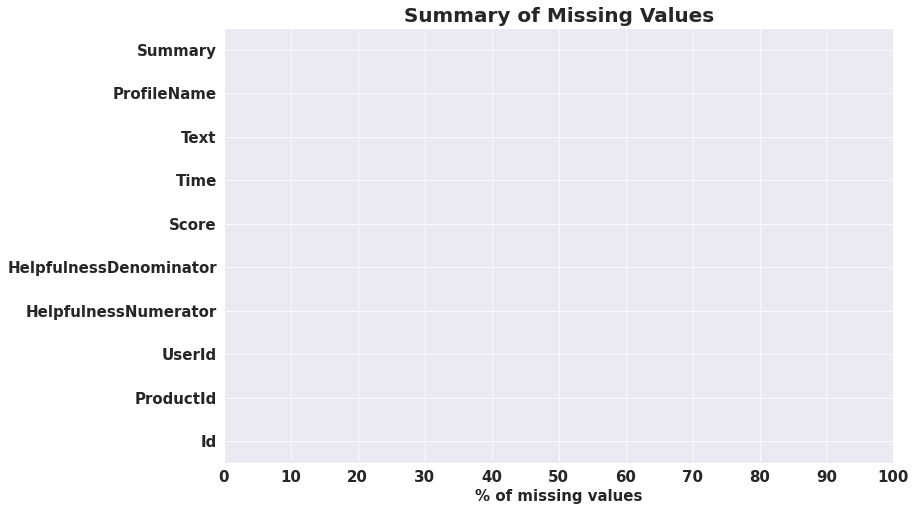

In [ ]:
(df.isna().sum()/ df.shape[0]* 100).sort_values().plot(kind='barh', figsize=(12,8))
plt.xticks(np.arange(0,110,10), fontsize=15, fontweight='bold')
plt.xlabel("% of missing values", fontsize=15, fontweight='bold')
plt.yticks(fontsize=15, fontweight='bold')
plt.title("Summary of Missing Values", fontsize=20, fontweight='bold')
plt.show()

We can see that Summary and Profile Name has some missing values but percentage value is less than even 0.5% so it will not effect the analysis.

In [ ]:
df.fillna("", inplace=True)

Here we are replacing all the null values with empty strings.

# Sentiment Analysis

In [ ]:
#dataframe for sentiment analysis
df_text = pd.DataFrame(df['Summary'] + " " + df['Text'], columns=['ReviewText'])

#creating the label and appending to the dataframe
df_text['Label'] = df['Score'].apply(lambda x: "Positive" if x >= 4 else "Negative")

In [ ]:
# removing the HTML tags
tag = re.compile("<.*?>")
df_text['CleanedText'] = df_text['ReviewText'].apply(lambda x: re.sub(tag, " ", x))

Lets see the distribution of reviews between positive and negative

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


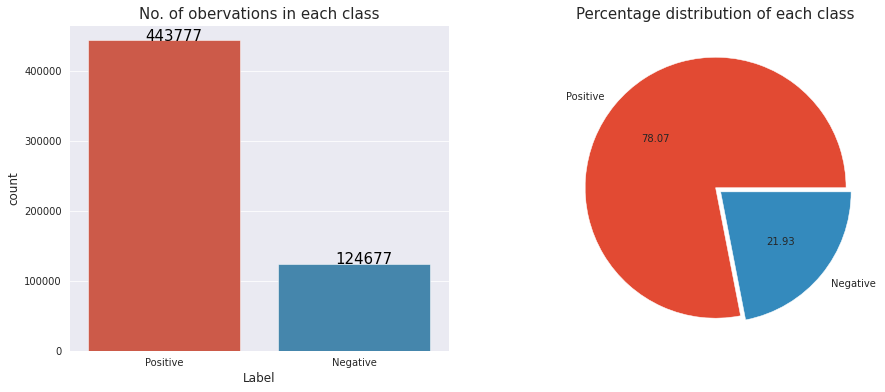

In [ ]:
# class distribution
plt.subplots(1,2, figsize=(15,6))

plt.subplot(1,2,1)
ax = sns.countplot(df_text['Label'])
#plt.xticks([0,1], labels=['Negative', 'Positive'])
plt.title('No. of obervations in each class', fontsize=15)
for i in ax.patches:
    # get_x pulls left or right; get_height pushes up or down
    ax.text(i.get_x()+0.3, i.get_height(), str(round(i.get_height(), 2)), fontsize=15, color='black')

# pie chart to visualize the percentage distribution of each class
plt.subplot(1,2,2)
plt.pie(df_text['Label'].value_counts(), labels=['Positive', 'Negative'], autopct='%.2f', explode=[0, 0.05])
plt.title('Percentage distribution of each class', fontsize=15)

plt.show()

We can also construct a word cloud to find trends between the two types of reviews.

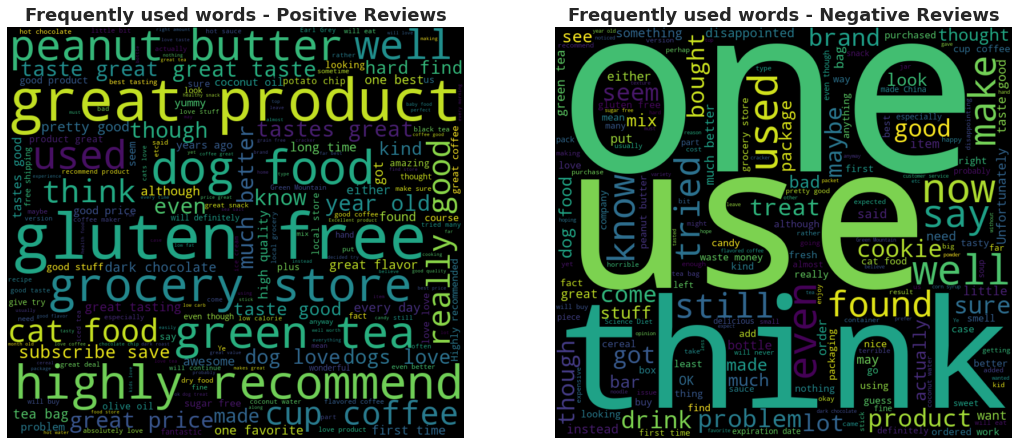

In [ ]:
plt.subplots(1,2, figsize=(18,8))

# word cloud - positive sentiment
plt.subplot(1,2,1)
corpus = " ".join(df_text.loc[(df_text['Label'] == "Positive"), "CleanedText"].to_numpy().tolist())
wordcloud = WordCloud(width=800, height=720, background_color="black").generate(corpus)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title("Frequently used words - Positive Reviews", fontsize=18, fontweight='bold')

# word cloud - negative sentiment
plt.subplot(1,2,2)
corpus = " ".join(df_text.loc[(df_text['Label'] == "Negative"), "CleanedText"].to_numpy().tolist())
wordcloud = WordCloud(width=800, height=720, background_color="black").generate(corpus)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title("Frequently used words - Negative Reviews", fontsize=18, fontweight='bold')

plt.show()

We can see most of the user reviews are about  taste and flavor since these are food products. Some others are about price, smell, texture.



# Feature analysis
Extracting Sentiment from the reviews

In [ ]:
# Removing data allows for quicker creation of figures
print(f"prior shape: {df.shape}")
dropRatio = .9
drop_indices = np.random.choice(df.index, int(df.shape[0]*dropRatio), replace=False)
df_dropped = df.drop(drop_indices)
print(f"after dropping randomly shape: {df_dropped.shape}")

prior shape: (568454, 10)
after dropping randomly shape: (56846, 10)


In [ ]:
# HelpfulnessRatio
df_dropped['HelpfulnessRatio'] = df_dropped['HelpfulnessNumerator'] / df_dropped['HelpfulnessDenominator']

# replacing the NaN values with 0
df_dropped['HelpfulnessRatio'].fillna(0, inplace=True)

SummaryLength

In [ ]:
df_dropped['SummaryLength'] = df_dropped['Summary'].str.len()
df_dropped['SummaryTokens'] = df_dropped['Summary'].apply(lambda x: tokenize_text(x, keep_punctuation="!"))
df_dropped['TextLength'] = df_dropped['Text'].str.len()
df_dropped['TextTokens'] = df_dropped['Text'].apply(lambda x: tokenize_text(x, keep_punctuation="!"))
df_dropped['ReviewText'] = df_dropped['Summary'] + " " + df['Text']
df_dropped['ReviewLength'] = df_dropped['ReviewText'].str.len()
df_dropped['ReviewTokens'] = df_dropped['SummaryTokens'] + df_dropped['TextTokens']
df_dropped['NoOfTokens'] = df_dropped['ReviewTokens'].apply(lambda x: len(x))
df_dropped['NoOfPunctuations'] = df_dropped['ReviewTokens'].apply(lambda x: x.count("!"))

Correlation of variables

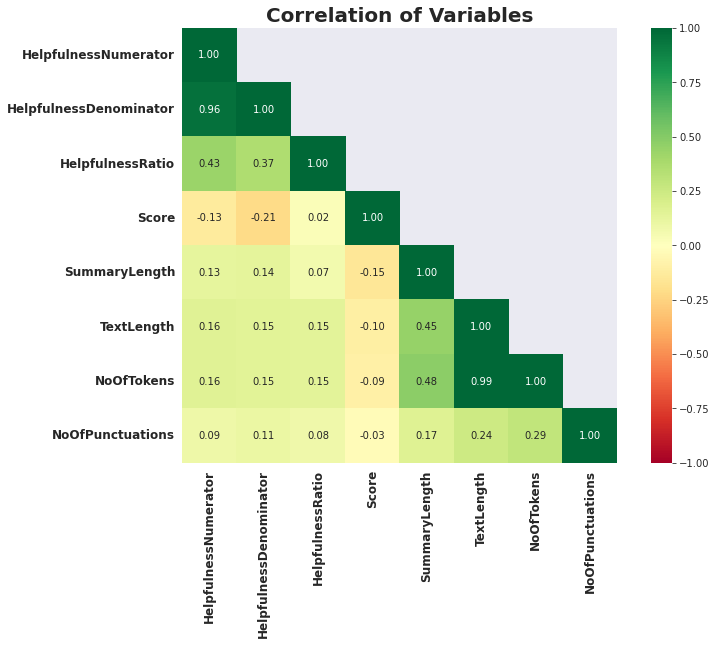

In [ ]:
# correlation plot of numerical values
plt.figure(figsize=(12,8))
corr_var = df_dropped[['HelpfulnessNumerator','HelpfulnessDenominator',
                       'HelpfulnessRatio','Score', 'SummaryLength',
                       'TextLength', 'NoOfTokens','NoOfPunctuations']].corr()
sns.heatmap(corr_var, annot=True, square=True, fmt='.2f', cmap='RdYlGn', vmin=-1, mask=np.triu(corr_var, 1))
plt.xticks(fontsize=12, fontweight='bold')
plt.yticks(fontsize=12, fontweight='bold')
plt.title("Correlation of Variables", fontsize=20, fontweight='bold')
plt.show()

Helpfulness as a function of length

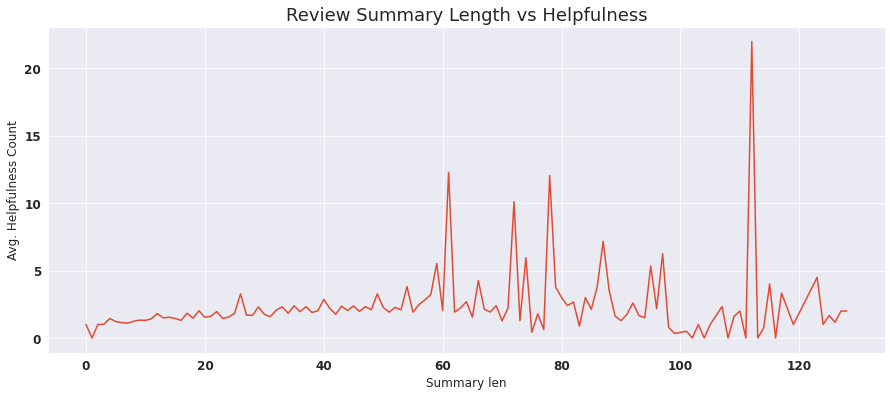

In [ ]:
plt.subplots(1,1, figsize=(15,6))
df_dropped.groupby('SummaryLength')['HelpfulnessNumerator'].mean().plot()
plt.xticks(fontsize=12, fontweight='bold')
plt.xlabel("Summary len", fontsize=12)
plt.yticks(fontsize=12, fontweight='bold')
plt.ylabel("Avg. Helpfulness Count", fontsize=12)
plt.title("Review Summary Length vs Helpfulness", fontsize=18)

plt.show()


# Model to predict sentiment
Building a Feed-forward Neural Network model and train it on the sentence embeddings to predict the sentiment.






To train a neural network, we cut down our data first

In [ ]:
print(f"prior shape: {df_text.shape}")
dropRatio = .99
drop_indices = np.random.choice(df_text.index, int(df_text.shape[0]*dropRatio), replace=False)
df_text_dropped = df_text.drop(drop_indices)
print(f"after dropping randomly shape: {df_text_dropped.shape}")

prior shape: (568454, 3)
after dropping randomly shape: (5685, 3)


In [ ]:
# splitting into train and test sets
X_train, X_test, y_train, y_test = train_test_split(df_text_dropped['CleanedText'], 
                                                    df_text_dropped['Label'],
                                                    test_size=0.2,
                                                    stratify=df_text_dropped['Label'])


In [ ]:
# positive reviews
positive_reviews = X_train[y_train == "Positive"].sample(n=sum(y_train == "Negative"), replace=False)

# negative reviews
negative_reviews = X_train[y_train == "Negative"]

# creating a down-sampled train set
df_pos = pd.DataFrame(positive_reviews, columns=['CleanedText'])
df_pos['Label'] = "Positive"
df_neg = pd.DataFrame(negative_reviews, columns=['CleanedText'])
df_neg['Label'] = "Negative"
df_train = df_pos.append(df_neg).reset_index(drop=True)
df_train = df_train.sample(frac=1, random_state=33)

# X_train and y_train
X_train = df_train['CleanedText']
y_train = df_train['Label']

In [ ]:
# encoding target variable
y_train = pd.get_dummies(y_train)
y_test = pd.get_dummies(y_test)

In [ ]:
# importing pre-trained universal sentence encoder
embed_use = hub.load("https://tfhub.dev/google/universal-sentence-encoder-large/5")

In [ ]:
# creating embeddings using universal sequential encoder
X_train = np.array([tf.reshape(embed_use([text]), [-1]).numpy() for text in tqdm(X_train)])


100%|██████████| 1988/1988 [04:39<00:00,  7.11it/s]


In [ ]:
# constructing a feed-forward neural network
model_predict_sentiment = keras.Sequential()
model_predict_sentiment.add(keras.layers.Dense(units=128, input_shape=(512, ), activation='relu'))
model_predict_sentiment.add(keras.layers.Dropout(rate=0.2))
model_predict_sentiment.add(keras.layers.Dense(units=64, activation='relu'))
model_predict_sentiment.add(keras.layers.Dropout(rate=0.2))
model_predict_sentiment.add(keras.layers.Dense(2, activation='softmax'))
model_predict_sentiment.compile(loss='categorical_crossentropy', optimizer=keras.optimizers.Adam(0.001), metrics=['accuracy'])
model_predict_sentiment.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 128)               65664     
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 64)                8256      
                                                                 
 dropout_1 (Dropout)         (None, 64)                0         
                                                                 
 dense_2 (Dense)             (None, 2)                 130       
                                                                 
Total params: 74,050
Trainable params: 74,050
Non-trainable params: 0
_________________________________________________________________


In [ ]:
# fitting the model with train data
train_history = model_predict_sentiment.fit(X_train, y_train,
                                              epochs=15,
                                              batch_size=16,
                                              validation_split=0.1,
                                              verbose=1,
                                              shuffle=True)

Epoch 1/15
112/112 [==============================] - 0s 3ms/step - loss: 0.0082 - accuracy: 0.9983 - val_loss: 0.5007 - val_accuracy: 0.8794
Epoch 2/15
112/112 [==============================] - 0s 3ms/step - loss: 0.0054 - accuracy: 0.9989 - val_loss: 0.5338 - val_accuracy: 0.8844
Epoch 3/15
112/112 [==============================] - 0s 3ms/step - loss: 0.0109 - accuracy: 0.9983 - val_loss: 0.5214 - val_accuracy: 0.8794
Epoch 4/15
112/112 [==============================] - 0s 3ms/step - loss: 0.0072 - accuracy: 0.9983 - val_loss: 0.5861 - val_accuracy: 0.8794
Epoch 5/15
112/112 [==============================] - 0s 3ms/step - loss: 0.0093 - accuracy: 0.9989 - val_loss: 0.5939 - val_accuracy: 0.8593
Epoch 6/15
112/112 [==============================] - 0s 3ms/step - loss: 0.0061 - accuracy: 0.9994 - val_loss: 0.5122 - val_accuracy: 0.8844
Epoch 7/15
112/112 [==============================] - 0s 3ms/step - loss: 0.0052 - accuracy: 0.9994 - val_loss: 0.6311 - val_accuracy: 0.8844
Epoch 

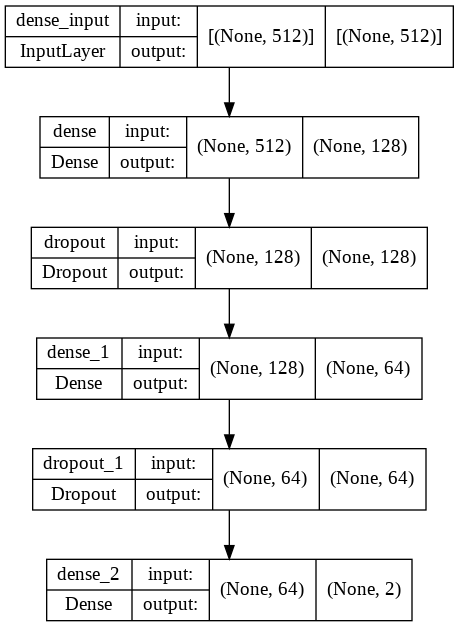

In [ ]:
plot_model(model_predict_sentiment, show_shapes=True, show_layer_names=True)

### Demonstrating predictive power of model

As we could see from our training, the model has already achived ~99% accuracy on the training set. Now to test on unseen data, the test set.

In [ ]:
# First use the sentence encoder
testData = np.array([tf.reshape(embed_use([text]), [-1]).numpy() for text in X_test])
test_accuracy = model_predict_sentiment.evaluate(testData, y_test)

36/36 [==============================] - 0s 2ms/step - loss: 0.6044 - accuracy: 0.8619


In [ ]:
print(f"Accuracy on test set: {test_accuracy[1]*100}%")

Accuracy on test set: 86.19173169136047%


In [ ]:
y_train.head()

,Negative,Positive
1216,1,0
957,0,1
1817,1,0
755,0,1
1538,1,0


Now we can demonstrate this on specific texts

In [ ]:
# Testing setiment on data
def predictOnData(data, model, embed):
  testData = np.array([tf.reshape(embed([text]), [-1]).numpy() for text in data])
  result = model_predict_sentiment.predict(testData)
  print(f"Probability positive: {result[0][1]}\n Probability Negative: {result[0][0]}")

In [ ]:
# Clear Answers
testData = ["I hate this product"]
predictOnData(testData, model_predict_sentiment, embed_use)
print('\n')
testData = ["I love this product"]
predictOnData(testData, model_predict_sentiment, embed_use)

Probability positive: 2.525546882736762e-09
 Probability Negative: 1.0


Probability positive: 1.0
 Probability Negative: 1.2074095889769154e-10


Clearly the model can figure out if these simple sentences are negative or positive. The resulting probabilities are extremely clear. But with real reviews, it will be more difficult.

In [ ]:
# Real review
testData = ["""Terrific book, one phywical problem with binding (a chapter was glued in upside down) 
but very clear exposition. Excellent review for applied math, machine learning, EE, physics students"""]
predictOnData(testData, model_predict_sentiment, embed_use)

Probability positive: 0.9999254941940308
 Probability Negative: 7.453028956661001e-05
